## Load Data

In [1]:
import pandas as pd
import numpy as np
import glob
from pyntcloud import PyntCloud

In [2]:
def load_ply(file_name):
    cloud = PyntCloud.from_file(file_name)
    return cloud.points.values

In [3]:
def load_obj(file_name):
    vertices = []
    with open(file_name) as f:
        for line in f:
            if line[:2] == 'v ':
                index1 = line.find(' ') + 1
                index2 = line.find(' ', index1 + 1)
                index3 = line.find(' ', index2 + 1)

                vertex = (float(line[index1:index2]), float(line[index2:index3]), float(line[index3:-1]))
                vertex = [round(vertex[0], 2), round(vertex[1], 2), round(vertex[2], 2)]
                vertices.append(np.array(vertex))
                
    return np.array(vertices)

In [4]:
def load_off(file_name):
    vertices = []
    with open(file_name) as f:
        for i, line in enumerate(f):
            vals = line.split(' ')
            if i > 2 and len(vals) == 3:
                vertex = [float(vals[0]), float(vals[1]), float(vals[2])]
                vertices.append(np.array(vertex))

    return np.random.permutation(np.array(vertices))[:2048]

## Create Dataset

In [15]:
from torch.utils.data import Dataset, DataLoader

In [48]:
class PointCloudDataset(Dataset):
    """Point cloud dataset."""

    def __init__(self, number=-1, directory='./data/04379243'):
        
        file_names = glob.glob('%s/*.ply' % directory)

        if number > 0 and len(file_names) > number:
            file_names = file_names[:number]
        
        point_clouds = []
        for file_name in file_names:

            points = load_ply(file_name)
            point_clouds.append(points)

        self.point_clouds = np.array(point_clouds, dtype='float64')

    def __len__(self):
        return len(self.point_clouds)

    def __getitem__(self, idx):

        return self.point_clouds[idx]

In [119]:
point_cloud_dataset = PointCloudDataset(100)
dataloader = DataLoader(point_cloud_dataset, batch_size=10, shuffle=True)

## Auto encoder

In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

In [121]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()

        self.conv1 = nn.Conv1d(2048, 256, 1)
        self.conv2 = nn.Conv1d(256, 128, 1)
        self.conv3 = nn.Conv1d(128, 64, 1)
        self.conv4 = nn.Conv1d(64, 32, 1)
        self.maxPool1d = nn.MaxPool1d(3)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxPool1d(x)
        return x

encoder = Encoder()
print(encoder)

Encoder(
  (conv1): Conv1d(2048, 256, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (conv4): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
  (maxPool1d): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
)


In [122]:
class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(32, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 2048*3)

    def forward(self, x):

        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = x.view(-1, 2048, 3)
        
        return x
    
decoder = Decoder()
print(decoder)

Decoder(
  (fc1): Linear(in_features=32, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6144, bias=True)
)


In [123]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

## Training

In [124]:
from lib.chamfer import ChamferLoss

model = AutoEncoder()

criterion = ChamferLoss()

num_epochs = 200
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

if torch.cuda.is_available:
    model = model.cuda()

for epoch in range(num_epochs):

    for data in dataloader:

        data = data.float()
        
        if torch.cuda.is_available:
            data = data.cuda()
            
        train_output = model(data)
        loss = criterion(train_output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch + 1) % 10 == 0:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data.mean()))

epoch [10/200], loss:54.6247
epoch [20/200], loss:55.8346
epoch [30/200], loss:27.6055
epoch [40/200], loss:30.1432
epoch [50/200], loss:22.8505
epoch [60/200], loss:20.0819
epoch [70/200], loss:23.0146
epoch [80/200], loss:16.1339
epoch [90/200], loss:24.6512
epoch [100/200], loss:18.3202
epoch [110/200], loss:13.4745
epoch [120/200], loss:15.0276
epoch [130/200], loss:17.0651
epoch [140/200], loss:13.4592
epoch [150/200], loss:13.6491
epoch [160/200], loss:12.1823
epoch [170/200], loss:13.2751
epoch [180/200], loss:10.8215
epoch [190/200], loss:22.5028
epoch [200/200], loss:15.3475


#### save

In [125]:
torch.save(encoder.state_dict(), './models/encoder.pt')
torch.save(decoder.state_dict(), './models/decoder.pt')

### get input values for validation

In [126]:
train_input  = next(iter(dataloader)).float()

if torch.cuda.is_available :
    train_output = model(train_input.cuda())
    train_output = train_output.cpu()
else:
    train_output = model(train_input)

In [127]:
v_encoder = Encoder()
v_decoder = Decoder()

v_encoder.load_state_dict(torch.load('./models/encoder.pt'))
v_decoder.load_state_dict(torch.load('./models/decoder.pt'))

## Generator

In [134]:
class Generator(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(Generator, self).__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):

        x = self.encoder(x)
        x[:,0,0] += 0.2
        x = self.decoder(x)
        
        return x

In [135]:
generator = Generator(v_encoder, v_decoder)
generator_output = generator(train_input)

## Validation

In [136]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

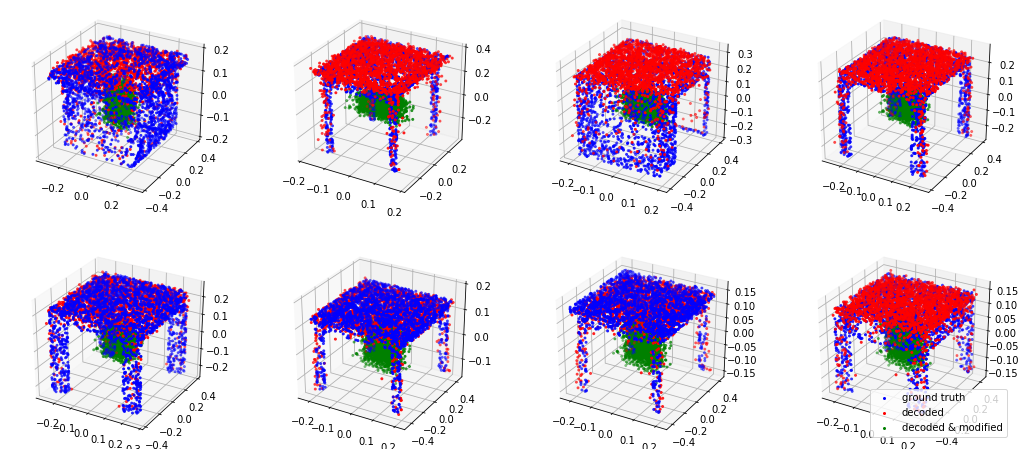

In [137]:
fig = plt.figure(figsize=(18, 8))

for i in range(8):
    
    row, columns, num = 2, 4, i + 1
    ax = fig.add_subplot(row, columns, num, projection='3d')

    data = train_input[i].detach().numpy().T
    ax.scatter(data[0], data[1], data[2], zdir='z', s=4, c='b', label='ground truth')

    data = train_output[i].detach().numpy().T
    ax.scatter(data[0], data[1], data[2], zdir='z', s=4, c='r', label='decoded')

    data = generator_output[i].detach().numpy().T
    ax.scatter(data[0], data[1], data[2], zdir='z', s=4, c='g', label='decoded & modified')

ax.legend()
plt.show()

## TODOs

* Create a mesh by marching cubes
* Manimulate latent vector or try something else to generate more nice images

## Misc

In [ ]:
input = torch.randn(10, 2048, 3)
print(input.shape)
m = nn.Conv1d(2048, 256, 1)
output = m(input)
print(output.shape)
m = nn.Conv1d(256, 128, 1)
output = m(output)
m = nn.Conv1d(128, 64, 1)
output = m(output)
print(output.shape)
m = nn.Conv1d(64, 32, 1)
output = m(output)
print(output.shape)
m = nn.MaxPool1d(3)
output = m(output)
print(output.shape)